In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# if the Breast Cancer dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df = pd.read_csv('wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
#建立SVM裡面的SCV分類器，做StandardScaler標準化
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
#建立網格，裡面的浮點數是超參數的C值
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
#內有兩個字典，每個字典代表一個網格類型，linear是線性的網格，rbf是亂數隨機的網格，代入param_range各種的浮點數，讓網格呈現各種不同的密集度
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  #選擇accuracy的分類模式
                  scoring='accuracy', 
                  #使用最佳參數重新訓練模型
                  refit=True,
                  cv=10)
#開始訓練
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [10]:
#將gs訓練出來的最佳參數模型的值丟給CLF
clf = gs.best_estimator_

# clf.fit(X_train, y_train) 
# note that we do not need to refit the classifier
# because this is done automatically via refit=True.

print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.974


In [11]:
from sklearn.model_selection import RandomizedSearchCV


pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1))

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

#這是不是用線性的網格去跑，是用亂數的網格跑，
rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        #跑幾次
                        n_iter=20,
                        #折數
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

In [12]:
rs = rs.fit(X_train, y_train)
print(rs.best_score_)

0.9737681159420291


In [13]:
print(rs.best_params_)

{'svc__kernel': 'rbf', 'svc__gamma': 0.001, 'svc__C': 10.0}


In [14]:
#跟上面建立的網格是一樣的，但是這次是用高效率的方式去跑

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

hs = HalvingRandomSearchCV(
    pipe_svc,
    param_distributions=param_grid,
    n_candidates='exhaust',
    resource='n_samples',
    factor=1.5,
    random_state=1,
    n_jobs=-1)
hs = hs.fit(X_train, y_train)
print(hs.best_score_)
print(hs.best_params_)

0.9676470588235293
{'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 100.0}


In [16]:
import scipy.stats
import numpy as np

param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

param_range = scipy.stats.loguniform(0.0001, 1000.0)

np.random.seed(1)
param_range.rvs(10)


array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [18]:

from sklearn.model_selection import cross_val_score
#把訓練內容分成2折
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
#把訓練內容分成5折，在5折中又分成2折，1折拿來訓練，1折拿來驗證
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')


CV accuracy: 0.974 +/- 0.015


In [19]:
from sklearn.tree import DecisionTreeClassifier
#gs的模型用決策數，參數給固定[1, 2, 3, 4, 5, 6, 7, None]，跟上面一樣，只有改說明內容
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy: 0.934 +/- 0.016


In [20]:
#建立一個2*2的圖形，TP(左上) FN(右上) FP(左下) TN(右下)
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
#把訓練出來的結果用confusion_matrix表示
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


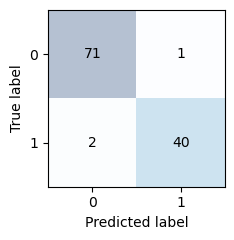

In [21]:
#繪製混淆矩陣的熱度圖
import matplotlib.pyplot as plt
#長寬2.5CM
fig, ax = plt.subplots(figsize=(2.5, 2.5))
#顏色
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
#訓練結果填進去
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('figures/06_09.png', dpi=300)
plt.show()

In [22]:
#以下都是混淆矩陣的應用
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


In [23]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


In [24]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
#精確率
pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')
#召回率
rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')
#F1分數
f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')
#馬修斯相關係數
mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.976
Recall: 0.952
F1: 0.964
MCC: 0.943
